# Testing the trained model on a random (full) image with ortho and normals (7 channels)

Using device: cuda
=== Loading images ===
Images loaded: RGBA (4002, 16126, 4), Normals (4002, 16126, 3)
=== Creating overlapping windows ===
Window size: (1280, 1280), Stride: 960
Created: 85 windows
=== Loading model ===
Model loaded: 4 classes
=== Performing segmentation ===


Segmenting windows: 100%|██████████| 85/85 [00:02<00:00, 34.20it/s]


=== Combining predictions with center weighting ===


Combining with center weighting: 100%|██████████| 85/85 [00:02<00:00, 29.57it/s]


RAW combined segmentation saved at: C:/Users/admin/Desktop/H_Bf_5_png-ortho_RAW_combined.png
=== Applying simple cleanup ===
=== Saving results ===
Grayscale segmentation saved at: C:/Users/admin/Desktop/H_Bf_5_png-ortho_segmented.png
Colored segmentation saved at: C:/Users/admin/Desktop/H_Bf_5_png-ortho_segmented_colored.png
Class information saved at: C:/Users/admin/Desktop/H_Bf_5_png-ortho_class_info.txt
=== Creating visualization ===


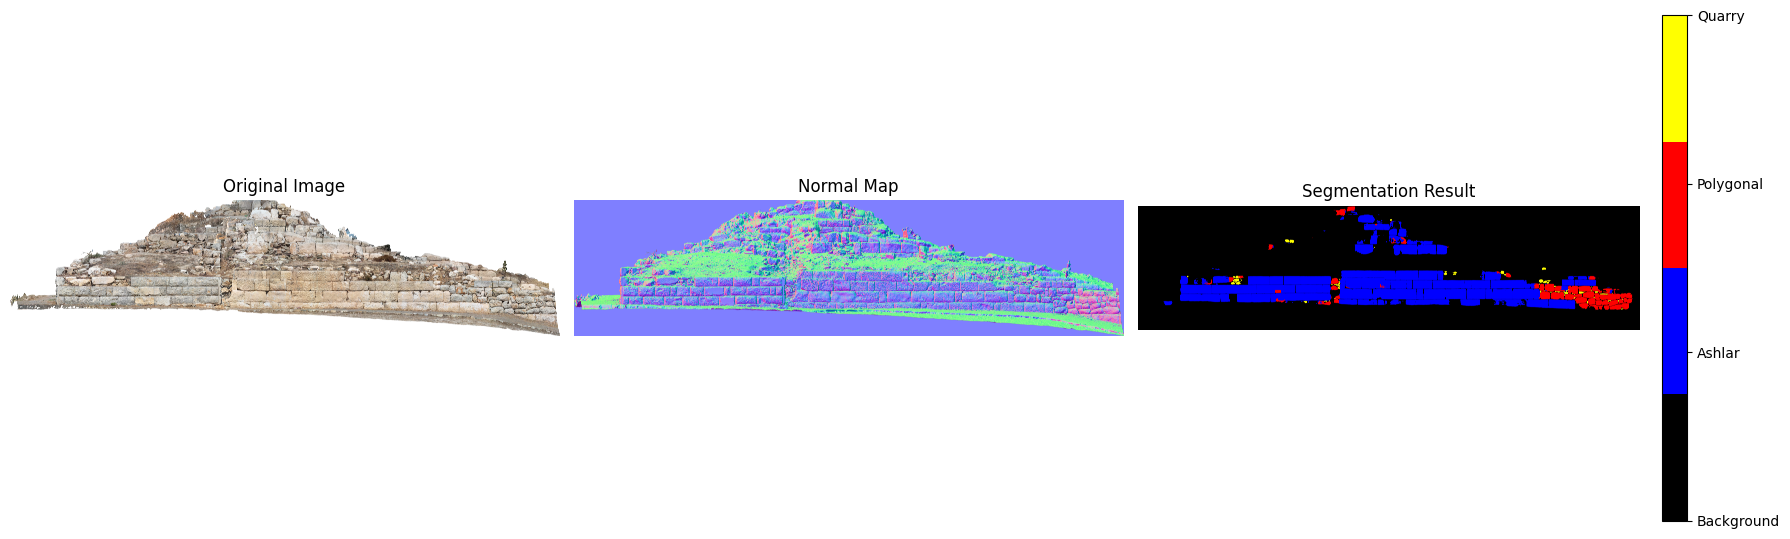

=== Segmentation complete! ===
This version uses:
- Original window size (1280x1280) for proper context
- Center-weighted combination to reduce edge artifacts
- Probability-based merging instead of hard voting
- Minimal post-processing to preserve model predictions


In [3]:
# ============================================================================
# STONE WALL SEGMENTATION WITH FIXED OVERLAP HANDLING
# ============================================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION SECTION - MODIFY THESE PARAMETERS
# ============================================================================

# === INPUT PATHS ===
RGBA_IMAGE_PATH ="C:/Users/admin/Desktop/Ordner fuer AmG Artikel Sommer 2025/AWS_TRAINING/2025-08-10_4classEX/testing/03_orthos/H_Bf_5_png-ortho.png"
NORMALS_IMAGE_PATH ="C:/Users/admin/Desktop/Ordner fuer AmG Artikel Sommer 2025/AWS_TRAINING/2025-08-10_4classEX/testing/04_normals/H_Bf_5_png-DEM_normalmap.png"
MODEL_PATH = "C:/Users/admin/Documents/GitHub/ancientwallsegmentation/2025-08-11_7-channel_4-class-EX_300.pth"

# === OUTPUT PATH ===
OUTPUT_DIR = "C:/Users/admin/Desktop/"

# === WINDOW PARAMETERS - BACK TO ORIGINAL ===
MODEL_SIZE = (512, 512)        # Size expected by the model
WINDOW_SIZE = (1280, 1280)     # Larger window for context
STRIDE = 960                   # 25% overlap

# === CLASS CONFIGURATION ===
CLASS_NAMES = [
    "Background",    # Class 0 - Black
    "Ashlar",       # Class 1 - Blue
    "Polygonal",    # Class 2 - Red  
    "Quarry"        # Class 3 - Yellow
]

CLASS_COLORS = [
    [0, 0, 0],      # Black - Background
    [0, 0, 255],    # Blue - Ashlar
    [255, 0, 0],    # Red - Polygonal
    [255, 255, 0]   # Yellow - Quarry
]

# === OVERLAP HANDLING ===
OVERLAP_METHOD = "center_weighted"  # Options: "average", "center_weighted", "max_confidence"

# === GPU/MEMORY MANAGEMENT ===
FALLBACK_TO_CPU = True          # Fallback to CPU if GPU runs out of memory

# === VISUALIZATION OPTIONS ===
SHOW_PLOTS = True               # Show matplotlib plots

# ============================================================================
# MODEL DEFINITION (DO NOT MODIFY)
# ============================================================================

class DoubleConv(nn.Module):
    """Double convolution block matching TensorFlow's implementation"""
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout_rate)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling exactly like TensorFlow's UpSampling2D + Conv2D"""
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv_after_up = nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1)
        self.conv = DoubleConv(in_channels, out_channels, dropout_rate)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.conv_after_up(x1)
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        if diffX != 0 or diffY != 0:
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class MultiUNet(nn.Module):
    def __init__(self, n_channels=7, n_classes=5):
        super(MultiUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 16, 0.1)
        self.down1 = Down(16, 32, 0.1)
        self.down2 = Down(32, 64, 0.2)
        self.down3 = Down(64, 128, 0.2)
        self.down4 = Down(128, 256, 0.3)
        
        self.up1 = Up(256, 128, 0.2)
        self.up2 = Up(128, 64, 0.2)
        self.up3 = Up(64, 32, 0.1)
        self.up4 = Up(32, 16, 0.1)
        self.outc = nn.Conv2d(16, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# ============================================================================
# PROCESSING FUNCTIONS
# ============================================================================

def load_images(rgba_path, normals_path):
    """Load RGBA and normal map images"""
    img_rgba = cv2.imread(rgba_path, cv2.IMREAD_UNCHANGED)
    if img_rgba is None:
        raise ValueError(f"Error loading RGBA image: {rgba_path}")
    if img_rgba.shape[2] != 4:
        print(f"WARNING: Image {rgba_path} doesn't have 4 channels, adding alpha channel.")
        alpha = np.ones((img_rgba.shape[0], img_rgba.shape[1], 1), dtype=img_rgba.dtype) * 255
        img_rgba = np.concatenate([img_rgba, alpha], axis=2)
    
    normals = cv2.imread(normals_path, cv2.IMREAD_COLOR)
    if normals is None:
        raise ValueError(f"Error loading normals image: {normals_path}")
    
    print(f"Images loaded: RGBA {img_rgba.shape}, Normals {normals.shape}")
    return img_rgba, normals

def create_sliding_windows(image, window_size, stride):
    """Create overlapping windows from an image"""
    height, width = image.shape[:2]
    windows = []
    positions = []
    
    for y in range(0, height, stride):
        for x in range(0, width, stride):
            y_end = min(y + window_size[0], height)
            x_end = min(x + window_size[1], width)
            
            y_start = max(0, y_end - window_size[0])
            x_start = max(0, x_end - window_size[1])
            
            window = image[y_start:y_end, x_start:x_end]
            
            if window.shape[0] != window_size[0] or window.shape[1] != window_size[1]:
                new_window = np.zeros((window_size[0], window_size[1], image.shape[2]), dtype=image.dtype)
                new_window[:window.shape[0], :window.shape[1]] = window
                window = new_window
                
            windows.append(window)
            positions.append((y_start, x_start, y_end, x_end))
    
    return windows, positions

def load_segmentation_model(model_path, device):
    """Load the pre-trained segmentation model"""
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    n_classes = checkpoint.get('n_classes', 5)
    img_channels = checkpoint.get('img_channels', 7)
    
    model = MultiUNet(n_channels=img_channels, n_classes=n_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model = model.to(device)
    model.eval()
    
    return model, n_classes

def segment_window_with_probabilities(model, rgb, alpha, normals, device='cuda'):
    """Segment a window and return both prediction and probabilities"""
    try:
        rgb_resized = cv2.resize(rgb, MODEL_SIZE, interpolation=cv2.INTER_AREA)
        alpha_resized = cv2.resize(alpha, MODEL_SIZE, interpolation=cv2.INTER_AREA)
        normals_resized = cv2.resize(normals, MODEL_SIZE, interpolation=cv2.INTER_AREA)
        
        if alpha_resized.ndim == 2:
            alpha_resized = np.expand_dims(alpha_resized, axis=2)
        
        full_img = np.concatenate([rgb_resized, alpha_resized, normals_resized], axis=2)
        full_img_norm = full_img.astype('float32') / 255.0
        
        input_tensor = torch.FloatTensor(full_img_norm).permute(2, 0, 1).unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = model(input_tensor)
            # Get probabilities with softmax
            probs = F.softmax(logits, dim=1)
            pred_label = torch.argmax(logits, dim=1)[0].cpu().numpy()
            probs_np = probs[0].cpu().numpy()  # Shape: (n_classes, 512, 512)
        
        if device == 'cuda':
            torch.cuda.empty_cache()
        
        # Resize predictions back to window size
        pred_label_resized = cv2.resize(pred_label.astype(np.uint8), 
                                       (WINDOW_SIZE[1], WINDOW_SIZE[0]), 
                                       interpolation=cv2.INTER_NEAREST)
        
        # Resize probabilities - use INTER_LINEAR for smooth probabilities
        probs_resized = np.zeros((probs_np.shape[0], WINDOW_SIZE[0], WINDOW_SIZE[1]), dtype=np.float32)
        for c in range(probs_np.shape[0]):
            probs_resized[c] = cv2.resize(probs_np[c], 
                                         (WINDOW_SIZE[1], WINDOW_SIZE[0]), 
                                         interpolation=cv2.INTER_LINEAR)
        
        return pred_label_resized, probs_resized
        
    except RuntimeError as e:
        if "out of memory" in str(e) and device == 'cuda' and FALLBACK_TO_CPU:
            print("GPU out of memory, falling back to CPU...")
            torch.cuda.empty_cache()
            gc.collect()
            model = model.to('cpu')
            return segment_window_with_probabilities(model, rgb, alpha, normals, device='cpu')
        else:
            raise e

def combine_predictions_center_weighted(windows_data, positions, original_shape, n_classes):
    """Combine windows giving more weight to center pixels"""
    height, width = original_shape[:2]
    
    class_scores = np.zeros((height, width, n_classes), dtype=np.float32)
    weights = np.zeros((height, width), dtype=np.float32)
    
    # Create Gaussian-like weight for each window (center has more weight)
    h, w = WINDOW_SIZE
    y_coords, x_coords = np.ogrid[:h, :w]
    center_y, center_x = h / 2, w / 2
    
    # Distance from center
    dist = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
    max_dist = np.sqrt(center_x**2 + center_y**2)
    
    # Weight: 1.0 at center, 0.3 at edges
    window_weight = 1.0 - (dist / max_dist) * 0.7
    
    with tqdm(total=len(windows_data), desc="Combining with center weighting") as pbar:
        for (pred, probs), (y_start, x_start, y_end, x_end) in zip(windows_data, positions):
            actual_h = y_end - y_start
            actual_w = x_end - x_start
            
            # Apply the weighted probabilities
            for c in range(n_classes):
                class_scores[y_start:y_end, x_start:x_end, c] += probs[c, :actual_h, :actual_w] * window_weight[:actual_h, :actual_w]
            
            weights[y_start:y_end, x_start:x_end] += window_weight[:actual_h, :actual_w]
            pbar.update(1)
    
    # Normalize by weights
    weights = np.maximum(weights, 1e-6)
    class_scores /= np.expand_dims(weights, axis=2)
    
    # Get final predictions
    segmentation = np.argmax(class_scores, axis=2).astype(np.uint8)
    
    return segmentation, class_scores

def simple_cleanup(segmentation):
    """Simple morphological cleanup without changing stone classifications"""
    cleaned = segmentation.copy()
    
    # Small median filter to smooth boundaries
    cleaned = cv2.medianBlur(cleaned.astype(np.uint8), 3)
    
    # Remove very small isolated pixels
    kernel = np.ones((3, 3), np.uint8)
    for class_id in range(1, 4):
        mask = (cleaned == class_id).astype(np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
        cleaned[cleaned == class_id] = 0
        cleaned[mask == 1] = class_id
    
    return cleaned

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def run_segmentation():
    """Main execution function"""
    
    # Setup
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Extract image name
    image_name = os.path.splitext(os.path.basename(RGBA_IMAGE_PATH))[0]
    
    # Load images
    print("=== Loading images ===")
    img_rgba, normals = load_images(RGBA_IMAGE_PATH, NORMALS_IMAGE_PATH)
    rgb = img_rgba[:, :, :3]
    alpha = img_rgba[:, :, 3:]
    
    # Create windows
    print("=== Creating overlapping windows ===")
    print(f"Window size: {WINDOW_SIZE}, Stride: {STRIDE}")
    rgb_windows, positions = create_sliding_windows(rgb, WINDOW_SIZE, STRIDE)
    alpha_windows, _ = create_sliding_windows(alpha, WINDOW_SIZE, STRIDE)
    normals_windows, _ = create_sliding_windows(normals, WINDOW_SIZE, STRIDE)
    print(f"Created: {len(rgb_windows)} windows")
    
    # Load model
    print("=== Loading model ===")
    model, n_classes = load_segmentation_model(MODEL_PATH, device)
    print(f"Model loaded: {n_classes} classes")
    
    # Validate class configuration
    if n_classes > len(CLASS_NAMES):
        print(f"WARNING: Model has {n_classes} classes, but only {len(CLASS_NAMES)} names defined!")
        for i in range(len(CLASS_NAMES), n_classes):
            CLASS_NAMES.append(f"Class {i}")
            color = cm.get_cmap('tab10')(i / 10)[:3]
            CLASS_COLORS.append((np.array(color) * 255).astype(int).tolist())
    
    # Perform segmentation with probabilities
    print("=== Performing segmentation ===")
    windows_data = []
    
    with tqdm(total=len(rgb_windows), desc="Segmenting windows") as pbar:
        for i in range(len(rgb_windows)):
            pred, probs = segment_window_with_probabilities(
                model, rgb_windows[i], alpha_windows[i], normals_windows[i], device
            )
            windows_data.append((pred, probs))
            pbar.update(1)
            
            if i % 10 == 0 and device == 'cuda':
                torch.cuda.empty_cache()
    
    # Combine predictions with center weighting
    print("=== Combining predictions with center weighting ===")
    full_segmentation, class_scores = combine_predictions_center_weighted(
        windows_data, positions, img_rgba.shape, n_classes
    )
    
    # Save raw output
    colors = np.array(CLASS_COLORS[:n_classes])
    output_raw_path = os.path.join(OUTPUT_DIR, f"{image_name}_RAW_combined.png")
    colored_raw = np.zeros((full_segmentation.shape[0], full_segmentation.shape[1], 3), dtype=np.uint8)
    for i in range(n_classes):
        colored_raw[full_segmentation == i] = colors[i]
    colored_raw_bgr = cv2.cvtColor(colored_raw, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_raw_path, colored_raw_bgr)
    print(f"RAW combined segmentation saved at: {output_raw_path}")
    
    # Apply simple cleanup
    print("=== Applying simple cleanup ===")
    full_segmentation = simple_cleanup(full_segmentation)
    
    # Save results
    print("=== Saving results ===")
    
    # Save grayscale segmentation
    output_path = os.path.join(OUTPUT_DIR, f"{image_name}_segmented.png")
    cv2.imwrite(output_path, full_segmentation)
    print(f"Grayscale segmentation saved at: {output_path}")
    
    # Save colored segmentation
    colored_segmentation = np.zeros((full_segmentation.shape[0], full_segmentation.shape[1], 3), dtype=np.uint8)
    for i in range(n_classes):
        colored_segmentation[full_segmentation == i] = colors[i]
    
    colored_segmentation_bgr = cv2.cvtColor(colored_segmentation, cv2.COLOR_RGB2BGR)
    output_colored_path = os.path.join(OUTPUT_DIR, f"{image_name}_segmented_colored.png")
    cv2.imwrite(output_colored_path, colored_segmentation_bgr)
    print(f"Colored segmentation saved at: {output_colored_path}")
    
    # Save class information
    info_path = os.path.join(OUTPUT_DIR, f"{image_name}_class_info.txt")
    with open(info_path, 'w') as f:
        f.write("Center-Weighted Segmentation - Class Information:")
        f.write("-" * 50 + "")
        f.write(f"Window size: {WINDOW_SIZE}")
        f.write(f"Model input size: {MODEL_SIZE}")
        f.write(f"Stride: {STRIDE}")
        f.write(f"Overlap method: {OVERLAP_METHOD}")
        f.write("-" * 50 + "")
        
        for i in range(n_classes):
            pixel_count = np.sum(full_segmentation == i)
            percentage = (pixel_count / full_segmentation.size) * 100
            f.write(f"Class {i}: {CLASS_NAMES[i] if i < len(CLASS_NAMES) else f'Class {i}'}")
            f.write(f"  Color: RGB{tuple(colors[i])}")
            f.write(f"  Pixels: {pixel_count:,}")
            f.write(f"  Coverage: {percentage:.2f}%")
    
    print(f"Class information saved at: {info_path}")
    
    # Visualization
    if SHOW_PLOTS:
        print("=== Creating visualization ===")
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image
        rgb_display = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        axes[0].imshow(rgb_display)
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        
        # Normal map
        normals_display = cv2.cvtColor(normals, cv2.COLOR_BGR2RGB)
        axes[1].imshow(normals_display)
        axes[1].set_title("Normal Map")
        axes[1].axis("off")
        
        # Segmentation result
        cmap_seg = ListedColormap([np.array(color)/255.0 for color in CLASS_COLORS[:n_classes]])
        im = axes[2].imshow(full_segmentation, cmap=cmap_seg, vmin=0, vmax=n_classes-1)
        axes[2].set_title("Segmentation Result")
        axes[2].axis("off")
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
        cbar.set_ticks(range(n_classes))
        cbar.set_ticklabels([CLASS_NAMES[i] if i < len(CLASS_NAMES) else f'Class {i}' for i in range(n_classes)])
        
        plt.tight_layout()
        plt.show()
    
    return full_segmentation, colored_segmentation

# ============================================================================
# RUN THE SEGMENTATION
# ============================================================================

if __name__ == "__main__":
    segmentation_result, colored_result = run_segmentation()
    print("=== Segmentation complete! ===")
    print("This version uses:")
    print("- Original window size (1280x1280) for proper context")
    print("- Center-weighted combination to reduce edge artifacts")
    print("- Probability-based merging instead of hard voting")
    print("- Minimal post-processing to preserve model predictions")

# Probability Visualization for Paper Figure

This section addresses the reviewer's comment (Line 417) about demonstrating the "subjective" character of manual interpretation vs. machine segmentation.

**Key difference:**
- **Manual classification:** Each region gets a single categorical label (effectively 100% confidence)
- **ML segmentation:** Each pixel receives a probability distribution across all classes

The code below visualizes these probability distributions to make this transparency explicit.

In [4]:
# ============================================================================
# PROBABILITY VISUALIZATION - Run this AFTER the main segmentation cell above
# ============================================================================

def run_segmentation_with_probabilities():
    """
    Modified version of run_segmentation that returns class_scores
    for probability visualization.
    """
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    image_name = os.path.splitext(os.path.basename(RGBA_IMAGE_PATH))[0]
    
    print("=== Loading images ===")
    img_rgba, normals = load_images(RGBA_IMAGE_PATH, NORMALS_IMAGE_PATH)
    rgb = img_rgba[:, :, :3]
    alpha = img_rgba[:, :, 3:]
    
    print("=== Creating overlapping windows ===")
    rgb_windows, positions = create_sliding_windows(rgb, WINDOW_SIZE, STRIDE)
    alpha_windows, _ = create_sliding_windows(alpha, WINDOW_SIZE, STRIDE)
    normals_windows, _ = create_sliding_windows(normals, WINDOW_SIZE, STRIDE)
    print(f"Created: {len(rgb_windows)} windows")
    
    print("=== Loading model ===")
    model, n_classes = load_segmentation_model(MODEL_PATH, device)
    print(f"Model loaded: {n_classes} classes")
    
    print("=== Performing segmentation ===")
    windows_data = []
    with tqdm(total=len(rgb_windows), desc="Segmenting windows") as pbar:
        for i in range(len(rgb_windows)):
            pred, probs = segment_window_with_probabilities(
                model, rgb_windows[i], alpha_windows[i], normals_windows[i], device)
            windows_data.append((pred, probs))
            pbar.update(1)
            if i % 10 == 0 and device == 'cuda':
                torch.cuda.empty_cache()
    
    print("=== Combining predictions ===")
    full_segmentation, class_scores = combine_predictions_center_weighted(
        windows_data, positions, img_rgba.shape, n_classes)
    
    return full_segmentation, class_scores, rgb, normals, n_classes, image_name

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def visualize_pixel_probabilities(class_scores, x, y, class_names=CLASS_NAMES):
    """Show the probability distribution for a single pixel."""
    probs = class_scores[y, x, :]
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = ['black', 'blue', 'red', 'gold'][:len(class_names)]
    bars = ax.bar(class_names, probs * 100, color=colors, edgecolor='black')
    ax.set_ylabel('Probability (%)', fontsize=12)
    ax.set_xlabel('Masonry Class', fontsize=12)
    ax.set_title(f'Class Probabilities at Pixel ({x}, {y})', fontsize=14)
    ax.set_ylim(0, 100)
    for bar, prob in zip(bars, probs):
        ax.annotate(f'{prob*100:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()
    return {name: f"{prob*100:.1f}%" for name, prob in zip(class_names, probs)}

def create_probability_heatmaps(class_scores, class_names=CLASS_NAMES, save_path=None):
    """Create heatmaps showing probability for each class."""
    n_classes = min(class_scores.shape[2], len(class_names))
    fig, axes = plt.subplots(1, n_classes, figsize=(4*n_classes, 4))
    if n_classes == 1: axes = [axes]
    for i, (ax, name) in enumerate(zip(axes, class_names[:n_classes])):
        im = ax.imshow(class_scores[:, :, i], cmap='viridis', vmin=0, vmax=1)
        ax.set_title(f'{name}\nProbability', fontsize=12)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.suptitle('Per-Class Probability Maps', fontsize=14, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()

def create_uncertainty_map(class_scores, save_path=None):
    """Create confidence and uncertainty maps."""
    max_probs = np.max(class_scores, axis=2)
    eps = 1e-10
    entropy = -np.sum(class_scores * np.log(class_scores + eps), axis=2)
    normalized_entropy = entropy / np.log(class_scores.shape[2])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    im1 = axes[0].imshow(max_probs, cmap='RdYlGn', vmin=0.25, vmax=1.0)
    axes[0].set_title('Prediction Confidence\n(Max class probability)', fontsize=12)
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    
    im2 = axes[1].imshow(normalized_entropy, cmap='hot', vmin=0, vmax=1)
    axes[1].set_title('Classification Uncertainty\n(Entropy)', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    
    plt.suptitle('Probabilistic Uncertainty Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    return max_probs, normalized_entropy

def create_comparison_figure_for_paper(class_scores, segmentation, rgb_image,
                                       sample_points=None, save_path=None):
    """Create comprehensive figure for paper - addresses reviewer comment."""
    if sample_points is None:
        h, w = segmentation.shape
        sample_points = [(w//4, h//4), (w//2, h//2), (3*w//4, 3*h//4)]
    n_points = len(sample_points)
    fig = plt.figure(figsize=(16, 10))
    
    # Top row: images
    ax1 = fig.add_subplot(2, 3, 1)
    rgb_display = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    ax1.imshow(rgb_display)
    ax1.set_title('Original Orthomosaic', fontsize=12)
    ax1.axis('off')
    for i, (x, y) in enumerate(sample_points):
        ax1.plot(x, y, 'wo', markersize=15, markeredgecolor='black', markeredgewidth=2)
        ax1.annotate(f'{i+1}', (x, y), color='black', fontsize=10, ha='center', va='center', fontweight='bold')
    
    ax2 = fig.add_subplot(2, 3, 2)
    colors_norm = np.array(CLASS_COLORS[:len(CLASS_NAMES)]) / 255.0
    cmap_seg = ListedColormap(colors_norm)
    ax2.imshow(segmentation, cmap=cmap_seg, vmin=0, vmax=len(CLASS_NAMES)-1)
    ax2.set_title('Segmentation (argmax)', fontsize=12)
    ax2.axis('off')
    for i, (x, y) in enumerate(sample_points):
        ax2.plot(x, y, 'wo', markersize=15, markeredgecolor='black', markeredgewidth=2)
        ax2.annotate(f'{i+1}', (x, y), color='black', fontsize=10, ha='center', va='center', fontweight='bold')
    
    ax3 = fig.add_subplot(2, 3, 3)
    max_probs = np.max(class_scores, axis=2)
    im = ax3.imshow(max_probs, cmap='RdYlGn', vmin=0.25, vmax=1.0)
    ax3.set_title('Prediction Confidence', fontsize=12)
    ax3.axis('off')
    plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
    
    # Bottom row: probability distributions
    for i, (x, y) in enumerate(sample_points):
        ax = fig.add_subplot(2, n_points, n_points + i + 1)
        probs = class_scores[y, x, :]
        predicted_class = np.argmax(probs)
        colors = ['black', 'blue', 'red', 'gold'][:len(CLASS_NAMES)]
        bars = ax.bar(range(len(CLASS_NAMES)), probs[:len(CLASS_NAMES)] * 100, color=colors, edgecolor='black')
        if predicted_class < len(bars):
            bars[predicted_class].set_edgecolor('lime')
            bars[predicted_class].set_linewidth(3)
        ax.set_ylabel('Probability (%)')
        ax.set_xticks(range(len(CLASS_NAMES)))
        ax.set_xticklabels(['BG', 'Ash', 'Poly', 'Qua'][:len(CLASS_NAMES)], fontsize=9)
        ax.set_ylim(0, 100)
        class_name = CLASS_NAMES[predicted_class] if predicted_class < len(CLASS_NAMES) else f'Class {predicted_class}'
        ax.set_title(f'Point {i+1}: Predicted {class_name}', fontsize=10)
        for bar, prob in zip(bars, probs[:len(CLASS_NAMES)]):
            if prob > 0.05:
                ax.annotate(f'{prob*100:.0f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                           xytext=(0, 2), textcoords="offset points", ha='center', fontsize=8)
    
    plt.suptitle('Neural Network Probability Output vs. Binary Classification\n'
                 'Each pixel receives a probability distribution, not a single label',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()

def print_probability_statistics(class_scores, segmentation):
    """Print statistics for paper text."""
    max_probs = np.max(class_scores, axis=2)
    non_bg_mask = segmentation > 0
    print("=" * 60)
    print("PROBABILITY DISTRIBUTION STATISTICS")
    print("=" * 60)
    print("\nManual classification: Always 100% confidence")
    print("Model output: Nuanced probability distributions\n")
    print(f"Overall - Mean confidence: {max_probs.mean()*100:.1f}%")
    print(f"Overall - Median confidence: {np.median(max_probs)*100:.1f}%")
    if non_bg_mask.sum() > 0:
        stone_probs = max_probs[non_bg_mask]
        print(f"\nStone pixels - Mean confidence: {stone_probs.mean()*100:.1f}%")
        print(f"Stone pixels - Min confidence: {stone_probs.min()*100:.1f}%")
    print("\nConfidence distribution:")
    for thresh in [0.5, 0.7, 0.9, 0.95]:
        pct = (max_probs >= thresh).sum() / max_probs.size * 100
        print(f"  Pixels >= {thresh*100:.0f}% confidence: {pct:.1f}%")
    print("\nPer-class analysis:")
    for i, name in enumerate(CLASS_NAMES):
        if i >= class_scores.shape[2]: break
        class_mask = segmentation == i
        if class_mask.sum() > 0:
            class_probs = class_scores[class_mask, i]
            print(f"  {name}: {class_mask.sum():,} px, mean prob {class_probs.mean()*100:.1f}%")

In [5]:
# ============================================================================
# RUN PROBABILITY ANALYSIS
# ============================================================================

print("Running segmentation with probability analysis...")
full_segmentation, class_scores, rgb, normals, n_classes, image_name = run_segmentation_with_probabilities()
print("\nSegmentation complete! Now generating probability visualizations...")

Running segmentation with probability analysis...
Using device: cuda
=== Loading images ===
Images loaded: RGBA (4002, 16126, 4), Normals (4002, 16126, 3)
=== Creating overlapping windows ===
Created: 85 windows
=== Loading model ===
Model loaded: 4 classes
=== Performing segmentation ===


Segmenting windows: 100%|██████████| 85/85 [00:02<00:00, 39.85it/s]


=== Combining predictions ===


Combining with center weighting: 100%|██████████| 85/85 [00:02<00:00, 30.38it/s]



Segmentation complete! Now generating probability visualizations...


In [13]:
# ============================================================================
# SAMPLE POINT CONFIGURATION - Modify these for your image!
# ============================================================================

h, w = full_segmentation.shape
#SAMPLE_POINTS = [
#    (w // 4, h // 4),        # Top-left region
#    (w // 2, h // 2),        # Center
#    (3 * w // 4, 3 * h // 4) # Bottom-right region
#]

# Or manually specify interesting points:
SAMPLE_POINTS = [(4000, 2500), (8000, 2400), (14000, 3000)]

print(f"Sample points: {SAMPLE_POINTS}")

Sample points: [(4000, 2500), (8000, 2400), (14000, 3000)]


Saved: C:/Users/admin/Desktop/H_Bf_5_png-ortho_probability_comparison.png


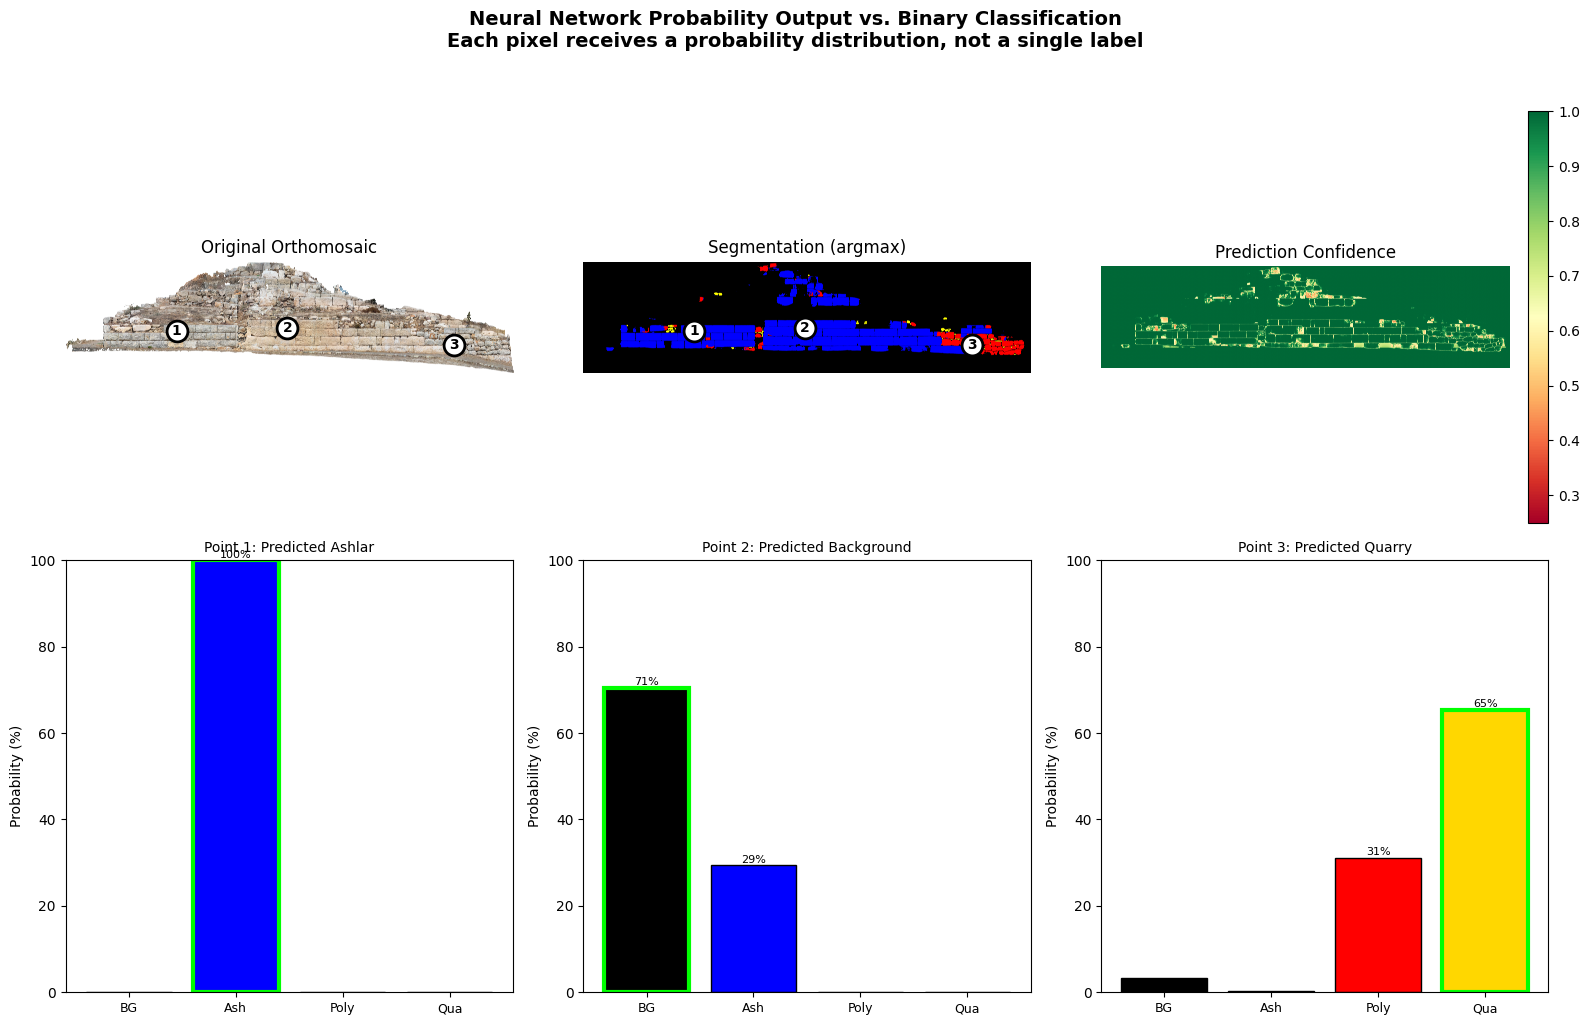

In [14]:
# ============================================================================
# 1. MAIN FIGURE FOR PAPER (addresses reviewer comment Line 417)
# ============================================================================

create_comparison_figure_for_paper(
    class_scores, full_segmentation, rgb,
    sample_points=SAMPLE_POINTS,
    save_path=os.path.join(OUTPUT_DIR, f"{image_name}_probability_comparison.png")
)

In [15]:
# ============================================================================
# 2. STATISTICS FOR PAPER TEXT
# ============================================================================

print_probability_statistics(class_scores, full_segmentation)

PROBABILITY DISTRIBUTION STATISTICS

Manual classification: Always 100% confidence
Model output: Nuanced probability distributions

Overall - Mean confidence: 98.0%
Overall - Median confidence: 100.0%

Stone pixels - Mean confidence: 95.1%
Stone pixels - Min confidence: 27.2%

Confidence distribution:
  Pixels >= 50% confidence: 99.8%
  Pixels >= 70% confidence: 97.1%
  Pixels >= 90% confidence: 93.9%
  Pixels >= 95% confidence: 92.3%

Per-class analysis:
  Background: 51,338,734 px, mean prob 98.7%
  Ashlar: 11,184,408 px, mean prob 95.8%
  Polygonal: 1,780,820 px, mean prob 90.8%
  Quarry: 232,290 px, mean prob 91.9%


Saved: C:/Users/admin/Desktop/H_Bf_5_png-ortho_class_probability_heatmaps.png


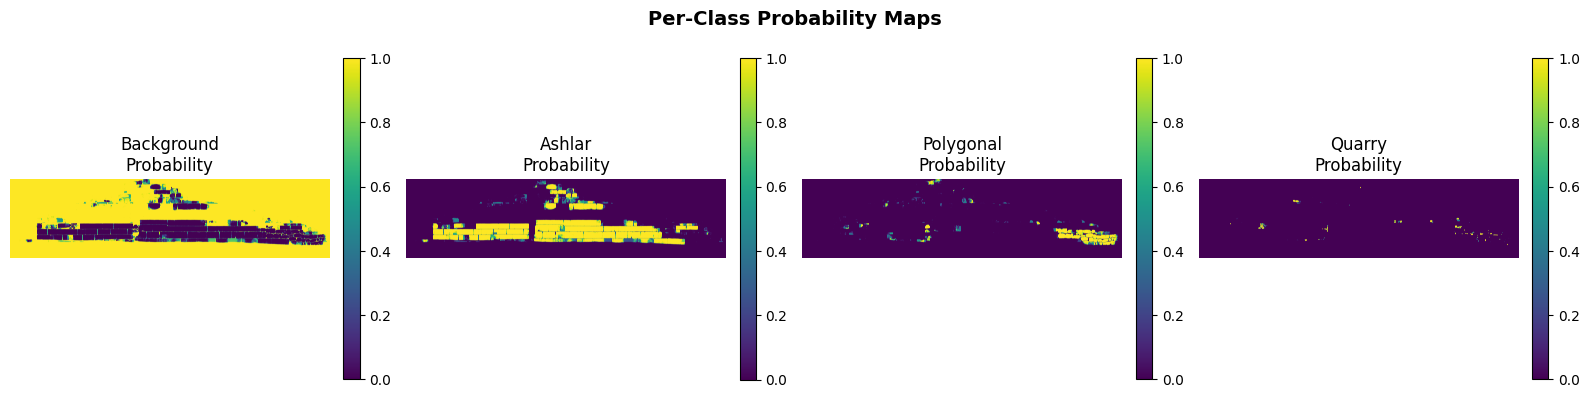

In [16]:
# ============================================================================
# 3. PER-CLASS PROBABILITY HEATMAPS
# ============================================================================

create_probability_heatmaps(
    class_scores,
    save_path=os.path.join(OUTPUT_DIR, f"{image_name}_class_probability_heatmaps.png")
)

Saved: C:/Users/admin/Desktop/H_Bf_5_png-ortho_uncertainty_map.png


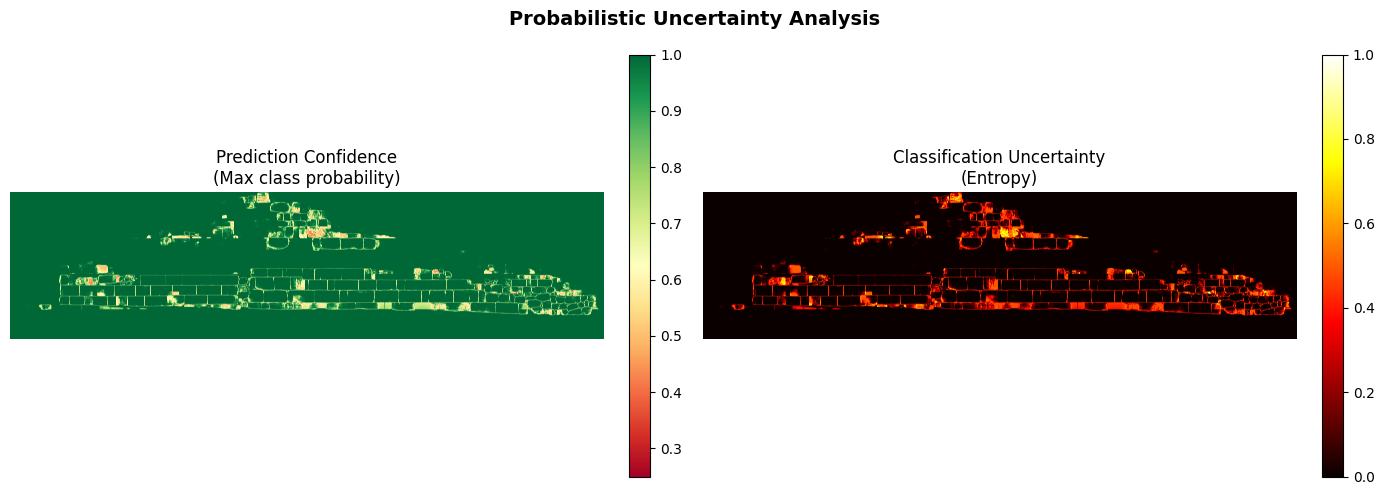

In [17]:
# ============================================================================
# 4. UNCERTAINTY/CONFIDENCE MAPS
# ============================================================================

max_probs, uncertainty = create_uncertainty_map(
    class_scores,
    save_path=os.path.join(OUTPUT_DIR, f"{image_name}_uncertainty_map.png")
)

Pixel (4200, 3000): Predicted class = Ashlar


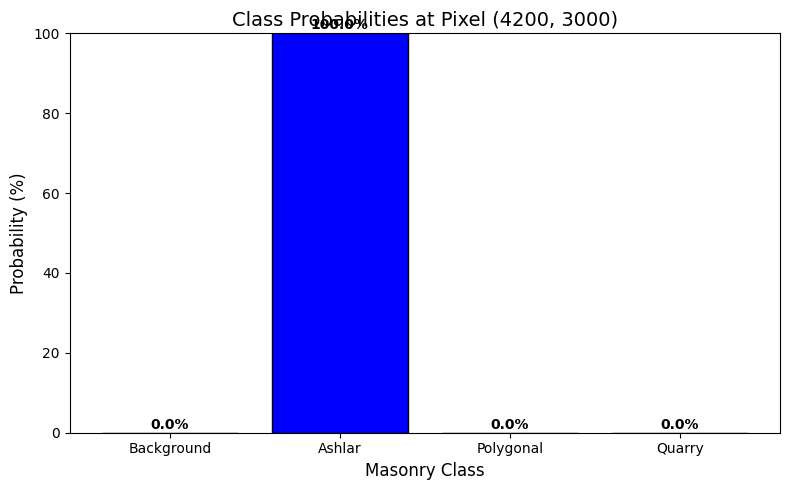

{'Background': '0.0%',
 'Ashlar': '100.0%',
 'Polygonal': '0.0%',
 'Quarry': '0.0%'}

In [19]:
# ============================================================================
# 5. INTERACTIVE: Explore probability at any pixel
# ============================================================================

x, y = 4200, 3000  # <-- MODIFY THESE COORDINATES

print(f"Pixel ({x}, {y}): Predicted class = {CLASS_NAMES[full_segmentation[y, x]]}")
visualize_pixel_probabilities(class_scores, x, y)